In [48]:
import bs4, requests, json
import pandas as pd
from statistics import mean, median
from tqdm import tqdm
import ast
import re
from googlesearch import search
import numpy as np

# List of all contests (gym = true)

In [3]:
url = "http://codeforces.com/api/contest.list?gym=true"

res = requests.get(url)

soup = bs4.BeautifulSoup(res.text,'html.parser')
newDictionary=json.loads(str(soup))

all_contests_df = pd.DataFrame(newDictionary['result'])

all_contests_df.head()


,id,name,type,phase,frozen,durationSeconds,startTimeSeconds,relativeTimeSeconds,preparedBy,websiteUrl,description,difficulty,country,kind,season,icpcRegion,city
0,103496,Abakoda 2021 Long Contest,IOI,CODING,False,799200,1.640599e+09,292503.0,Shisuko,https://noi.ph/abakoda-2021/,Abakoda 2021 is a series of online programming...,2.0,Philippines,NaN,NaN,NaN,NaN
1,100001,2010 Codeforces Beta Round #1 (training),ICPC,FINISHED,False,7200,NaN,NaN,NaN,NaN,This is the only contest for testing Codeforce...,3.0,NaN,Training Contest,2010-2011,NaN,NaN
2,100002,2002-2003 ACM-ICPC Northeastern European Regio...,ICPC,FINISHED,False,18000,NaN,NaN,MikeMirzayanov,NaN,NaN,4.0,Russia,Official ICPC Contest,2002-2003,Northeastern Europe Region,Saint Petersburg
3,100003,2008-2009 Всероссийская командная олимпиада шк...,ICPC,FINISHED,False,18000,1.453514e+09,187377303.0,Edvard,NaN,NaN,3.0,Russia,Official School Contest,2008-2009,NaN,Saint Petersburg
4,100004,Local Contest,ICPC,FINISHED,False,10800,1.511928e+09,128963703.0,MikeMirzayanov,NaN,NaN,3.0,Uzbekistan,Official School Contest,2017-2018,NaN,Namangan


In [4]:
all_contests_df.kind.value_counts()

Official ICPC Contest                         303
Official School Contest                       285
Training Contest                              244
School/University/City/Region Championship    201
Training Camp Contest                         126
Official International Personal Contest       113
Opencup Contest                                21
Name: kind, dtype: int64

In [6]:
opencup_contests_df = all_contests_df[all_contests_df.kind == 'Opencup Contest']
opencup_contests_df.to_csv('Data/contests/opencup_contests.csv', index=False)
opencup_contests_df.head()

,id,name,type,phase,frozen,durationSeconds,startTimeSeconds,relativeTimeSeconds,preparedBy,websiteUrl,description,difficulty,country,kind,season,icpcRegion,city
318,100514,Crypto Cup 1.0,ICPC,FINISHED,False,23400,1.414845e+09,226046703.0,Damon,http://eprint.iacr.org,Cryptography Open CUP,3.0,Iran,Opencup Contest,2014-2015,NaN,Tehran
346,100571,Hello 2015 (Div.2),ICPC,FINISHED,False,10800,1.420645e+09,220246503.0,PrinceOfPersia,NaN,NaN,3.0,Iran,Opencup Contest,2014-2015,NaN,Tehran
375,100633,"2015 ICL, Finals, Div. 1",ICPC,FINISHED,False,18000,NaN,NaN,Scalar,http://icl.ru/turnir/,NaN,4.0,Russia,Opencup Contest,2014-2015,NaN,Kazan’
376,100637,"2015 ICL, Finals, Div. 2",ICPC,FINISHED,False,18000,NaN,NaN,Scalar,http://icl.ru/turnir/,NaN,3.0,Russia,Opencup Contest,2014-2015,NaN,Kazan’
493,100917,"2015-2016 XVI Open Cup, Grand Prix of Bashkort...",ICPC,FINISHED,False,18000,1.457210e+09,183681903.0,MikeMirzayanov,http://opencup.ru/,NaN,4.0,Russia,Opencup Contest,2015-2016,NaN,Izhevsk


In [7]:
opencup_contests_ids = list(opencup_contests_df.id)

# Final standing of open cup contests

In [8]:
def clean_rows(df):
    # data = pd.DataFrame
    df['contestId'] = df.party.apply(lambda x: x['contestId'])
    df['members'] = df.party.apply(lambda x: x['members'] if x['members'] else [])
    df['teamName'] = df.party.apply(lambda x: x['teamName'] if ('teamName' in x.keys()) else '')
    df['participantType'] = df.party.apply(lambda x: x['participantType'] if ('participantType' in x.keys()) else '')
    df['ghost'] = df.party.apply(lambda x: x['ghost'] if ('ghost' in x.keys()) else '')
    return df




In [9]:
final_df = pd.DataFrame()
standing_dfs = []
problems_dfs = []
for i in opencup_contests_ids:
    url = "http://codeforces.com/api/contest.standings?contestId={}&from=1&count=150&showUnofficial=true".format(i)
    res = requests.get(url)
    while(res.status_code != 200):
        res = requests.get(url)
    soup = bs4.BeautifulSoup(res.text,'html.parser')
    newDictionary=json.loads(str(soup))
    standing_df = pd.DataFrame(newDictionary['result']['rows'])
    standing_dfs.append((clean_rows(standing_df)))
    problems_dfs.append(pd.DataFrame(newDictionary['result']['problems']))

In [10]:
standing_df = pd.concat(standing_dfs)
standing_df.to_csv('Data/contests/standing_opencup.csv', index=False)

In [11]:
probems_df = pd.concat(problems_dfs)
probems_df.to_csv('Data/contests/problems_opencup.csv', index=False)

In [70]:
standing_df_team = standing_df[standing_df.members.apply(lambda x: len(x)) == 3]

,party,rank,points,penalty,successfulHackCount,unsuccessfulHackCount,problemResults,contestId,members,teamName,participantType,ghost
2,"{'contestId': 100514, 'members': [{'handle': '...",3,18.0,1794,0,0,"[{'points': 1.0, 'rejectedAttemptCount': 0, 't...",100514,"[{'handle': 'Visconte'}, {'handle': 'Localhost...",Flareon,CONTESTANT,False
6,"{'contestId': 100514, 'members': [{'handle': '...",7,17.0,1196,0,0,"[{'points': 1.0, 'rejectedAttemptCount': 0, 't...",100514,"[{'handle': 'isthmus'}, {'handle': 'drazil'}, ...",mustworry,CONTESTANT,False
7,"{'contestId': 100514, 'members': [{'handle': '...",8,17.0,1818,0,0,"[{'points': 1.0, 'rejectedAttemptCount': 0, 't...",100514,"[{'handle': 'SkyDec'}, {'handle': 'zld3794955'...",OIER,CONTESTANT,False
10,"{'contestId': 100514, 'members': [{'handle': '...",11,16.0,1477,0,0,"[{'points': 1.0, 'rejectedAttemptCount': 0, 't...",100514,"[{'handle': 'LittleBella'}, {'handle': 'Konjac...",MagicDLF,CONTESTANT,False
16,"{'contestId': 100514, 'members': [{'handle': '...",17,14.0,1111,0,0,"[{'points': 1.0, 'rejectedAttemptCount': 0, 't...",100514,"[{'handle': 'Altria-PenDragon'}, {'handle': 's...",ZheJiaofans,CONTESTANT,False
...,...,...,...,...,...,...,...,...,...,...,...,...
38,"{'contestId': 103372, 'members': [{'handle': '...",39,3.0,344,0,0,"[{'points': 1.0, 'rejectedAttemptCount': 0, 't...",103372,"[{'handle': 'MoreSimple'}, {'handle': 'liangc_...",boom 0 happy,VIRTUAL,False
39,"{'contestId': 103372, 'members': [{'handle': '...",40,3.0,362,0,0,"[{'points': 1.0, 'rejectedAttemptCount': 0, 't...",103372,"[{'handle': 'Sharlet.x'}, {'handle': 'FYWRT050...",Code Comedians,VIRTUAL,False
34,"{'contestId': 103439, 'members': [{'handle': '...",35,9.0,1515,0,0,"[{'points': 1.0, 'rejectedAttemptCount': 0, 't...",103439,"[{'handle': 'stefanbalaz2'}, {'handle': 'Tadij...",Infinity,VIRTUAL,False
38,"{'contestId': 103439, 'members': [{'handle': '...",39,8.0,1378,0,0,"[{'points': 1.0, 'rejectedAttemptCount': 2, 't...",103439,"[{'handle': 'Gapzinho'}, {'handle': 'beza'}, {...",Amigos de Yuki U・ᴥ・U,VIRTUAL,False


In [ ]:
standing_df

# get data of users

In [12]:
def api_result(req):
    res = requests.get(req)
    soup = bs4.BeautifulSoup(res.text,'html.parser')
    newDictionary = json.loads(str(soup))
    return newDictionary
def get_users_info(x):
    req = "https://codeforces.com/api/user.info?handles="
    for i in x:
        req += i
        if i != x[-1]:
            req += ";"
    return api_result(req)

def get_submission_info(user, cnt = 100000): # returns 
    #print("CNT = ", cnt)
    req = f"https://codeforces.com/api/user.status?handle={user}&from=1&count={cnt}"
    x = api_result(req)
    #print(x['status'])
    if x['status'] != 'OK':
        print("BAD")
        assert(0)
    else:
        cnt_verdicts = {}
        list_rates = {}
        tag_info = {}
        for i in range(len(x['result'])):
            problem = x['result'][i]['problem']
            if not 'rating' in problem:
                continue
            rate = problem['rating']

            tags = problem['tags']
            verdict = x['result'][i]['verdict']
            if not verdict in cnt_verdicts:
                cnt_verdicts[verdict] = 0
            cnt_verdicts[verdict] = cnt_verdicts[verdict] + 1
            if verdict == 'OK':
                for tag in tags:
                    if not tag in list_rates:
                        list_rates[tag] = []
                    list_rates[tag].append(rate)

        for tag in list_rates.keys():
            rates = list_rates[tag]
            ans = {}
            ans["num"] = len(rates)
            ans["mean"] = mean(rates)
            ans["median"] = median(rates)
            tag_info[tag] = ans


        return tag_info, cnt_verdicts

In [13]:
users = ['tourist', 'Benq']


x = get_users_info(users)

In [14]:
print(x)

{'status': 'OK', 'result': [{'lastName': 'Korotkevich', 'country': 'Belarus', 'lastOnlineTimeSeconds': 1640884837, 'city': 'Gomel', 'rating': 3836, 'friendOfCount': 39535, 'titlePhoto': 'https://userpic.codeforces.org/422/title/50a270ed4a722867.jpg', 'handle': 'tourist', 'avatar': 'https://userpic.codeforces.org/422/avatar/2b5dbe87f0d859a2.jpg', 'firstName': 'Gennady', 'contribution': 175, 'organization': 'ITMO University', 'rank': 'legendary grandmaster', 'maxRating': 3870, 'registrationTimeSeconds': 1265987288, 'maxRank': 'legendary grandmaster'}, {'lastName': 'Qi', 'country': 'United States', 'lastOnlineTimeSeconds': 1640804555, 'city': 'Princeton', 'rating': 3548, 'friendOfCount': 8178, 'titlePhoto': 'https://userpic.codeforces.org/312472/title/7cf0a442d4071e87.jpg', 'handle': 'Benq', 'avatar': 'https://userpic.codeforces.org/312472/avatar/5716ac69aea8159a.jpg', 'firstName': 'Benjamin', 'contribution': 89, 'organization': 'MIT', 'rank': 'legendary grandmaster', 'maxRating': 3797, '

In [15]:
x, y = get_submission_info('Benq')

In [16]:
print(x)

{'dfs and similar': {'num': 301, 'mean': 2268.106312292359, 'median': 2300}, 'dp': {'num': 739, 'mean': 2421.6508795669824, 'median': 2400}, 'graphs': {'num': 417, 'mean': 2426.1390887290167, 'median': 2400}, 'bitmasks': {'num': 197, 'mean': 2335.02538071066, 'median': 2400}, 'combinatorics': {'num': 249, 'mean': 2458.2329317269077, 'median': 2500}, 'divide and conquer': {'num': 132, 'mean': 2625.757575757576, 'median': 2600.0}, 'math': {'num': 863, 'mean': 2097.7983777520276, 'median': 2100}, 'matrices': {'num': 63, 'mean': 2614.285714285714, 'median': 2600}, 'binary search': {'num': 333, 'mean': 2257.357357357357, 'median': 2200}, 'data structures': {'num': 726, 'mean': 2511.845730027548, 'median': 2500.0}, 'strings': {'num': 246, 'mean': 1993.0894308943089, 'median': 2000.0}, 'greedy': {'num': 698, 'mean': 1917.1919770773638, 'median': 1850.0}, 'brute force': {'num': 449, 'mean': 1945.879732739421, 'median': 1900}, 'implementation': {'num': 709, 'mean': 1588.0112834978843, 'median':

In [17]:
print(y)

{'OK': 3213, 'WRONG_ANSWER': 1558, 'TIME_LIMIT_EXCEEDED': 579, 'COMPILATION_ERROR': 125, 'RUNTIME_ERROR': 263, 'MEMORY_LIMIT_EXCEEDED': 50, 'SKIPPED': 9, 'PARTIAL': 29, 'CHALLENGED': 20, 'IDLENESS_LIMIT_EXCEEDED': 7, 'FAILED': 1}


In [18]:
top10 = ['tourist', 'Benq', 'maroonrk', 'Miracle03', 'peehs_moorhsum', 'Radewoosh', 'Petr', 'sunset', 'ko_osaga', 'jiangly']
print(len(top10))

10


In [19]:
def get_dataframe(users_list):
    data = {'user': [], 'tag_info': [], 'verdict_count': []}
    for user in tqdm(users_list):
        x, y = get_submission_info(user)
        data['user'].append(user)
        data['tag_info'].append(x)
        data['verdict_count'].append(y)
    df = pd.DataFrame(data)
    return df

In [20]:
users_df = get_dataframe(users_list=top10)
users_df.head()

100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


,user,tag_info,verdict_count
0,tourist,"{'dfs and similar': {'num': 214, 'mean': 2326....","{'OK': 1799, 'WRONG_ANSWER': 481, 'TIME_LIMIT_..."
1,Benq,"{'dfs and similar': {'num': 301, 'mean': 2268....","{'OK': 3213, 'WRONG_ANSWER': 1558, 'TIME_LIMIT..."
2,maroonrk,"{'dfs and similar': {'num': 157, 'mean': 2403....","{'OK': 1382, 'WRONG_ANSWER': 597, 'TIME_LIMIT_..."
3,Miracle03,"{'binary search': {'num': 71, 'mean': 2059.154...","{'WRONG_ANSWER': 491, 'OK': 582, 'TIME_LIMIT_E..."
4,peehs_moorhsum,"{'data structures': {'num': 76, 'mean': 2247.3...","{'OK': 337, 'MEMORY_LIMIT_EXCEEDED': 13, 'TIME..."


In [21]:
google_results = {}

# google username

In [42]:
def google_username_res(x):
    
    query = "codeforces user " + x
    for i in search(query, num=2, stop=2, pause=2):
        print(i)
    return -1

In [43]:
google_username_res("mohammad saneian")

HTTPError: HTTP Error 429: Too Many Requests

In [35]:
def google_username(x):
    if x in google_results.keys():
        return google_results[x]
    query = "codeforces user " + x
    #print(query)
    ht1 = 'http://codeforces.com/profile/'
    ht2 = 'https://codeforces.com/profile/'
    for i in search(query, tld="co.in", num=2, stop=2, pause=2):
        #print(i)
        for j in [ht1, ht2]:
            if i.startswith(j): 
                ans = ""
                for j in range(len(j), len(i)):
                    if i[j] == "?" or i[j] == "/":
                        break
                    ans += i[j]
                if ans != "":
                    google_results[x] = ans 
                    return ans
    google_results[x] = "404notfound"
    return "404notfound"

In [67]:
google_username('Mohammad saneian') # 

HTTPError: HTTP Error 429: Too Many Requests

In [ ]:
users_df.to_csv('Data/users/users.csv', index=False)

In [26]:
standing = pd.read_csv("Data/contests/standing_opencup.csv")
#standing = standing.loc[standing["participantType"] == "CONTESTANT"]
print(len(standing))
#standing = standing.loc[standing["ghost"] == True]
#print(len(standing))

3105


In [ ]:
tags =  list(users_df.tag_info[0].keys())

In [59]:
users_performance_df = pd.DataFrame()

def get_tag_performance(a, tag):

    try:
        return a[tag]['median']
    except:
        return np.nan


In [57]:
users_df.head()

,user,tag_info,verdict_count
0,tourist,"{'dfs and similar': {'num': 214, 'mean': 2326....","{'OK': 1799, 'WRONG_ANSWER': 481, 'TIME_LIMIT_..."
1,Benq,"{'dfs and similar': {'num': 301, 'mean': 2268....","{'OK': 3213, 'WRONG_ANSWER': 1558, 'TIME_LIMIT..."
2,maroonrk,"{'dfs and similar': {'num': 157, 'mean': 2403....","{'OK': 1382, 'WRONG_ANSWER': 597, 'TIME_LIMIT_..."
3,Miracle03,"{'binary search': {'num': 71, 'mean': 2059.154...","{'WRONG_ANSWER': 491, 'OK': 582, 'TIME_LIMIT_E..."
4,peehs_moorhsum,"{'data structures': {'num': 76, 'mean': 2247.3...","{'OK': 337, 'MEMORY_LIMIT_EXCEEDED': 13, 'TIME..."


In [61]:
for t in tags:
    users_performance_df[t] = users_df.tag_info.apply(lambda x: get_tag_performance(x, t))

users_performance_df['ID'] = users_df.user


In [66]:
users_performance_df.shape

(10, 38)

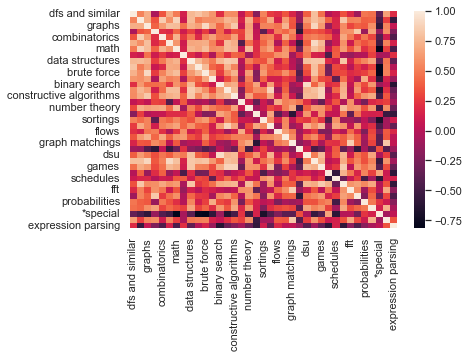

In [65]:
import seaborn as sns; sns.set_theme()

ax = sns.heatmap(users_performance_df.corr())

In [32]:
ghost = standing["ghost"].tolist()
party = standing["party"].tolist()
members = standing["members"].tolist()
cnt, yes, no = 0, 0, 0
for i in range(0, len(ghost)):
    if ghost[i] == True:
        x = ast.literal_eval(party[i])['teamName']
        res = x.find(": ")
        if(res == -1):
            members[i] = "[]"
        else:
            cnt += 1
            y = x[res+2:]
            haha = y.split(", ")
            users = []
            for query in haha:
                ans = google_username(query)
                #print(query, ans)
                if ans != '404notfound':
                    users.append(ans)
            #print(users)
            
            
            if len(users) == len(haha):
                members[i] = str(users)
                yes += 1
            else:
                members[i] = "[]"
                no += 1
            print(members[i])
            print(":D", i, "out of ", len(ghost))
        # if cnt >= 5:
        #     break
    else:
        x = ast.literal_eval(members[i])
        y = []
        for j in x:
            y.append(j['handle'])
        members[i] = str(y)
print("successfull searchs resulting complete teams = ", yes)
print("unsuccessfull searchs resulting incomplete teams = ", no)

['zeliboba', 'ArtDitel', 'zhukovdm']
:D 305 out of  3105
['AlexFetisov', 'winger', 'RAD']
:D 306 out of  3105


HTTPError: HTTP Error 429: Too Many Requests

In [154]:
print(members[:10])

["['peter50216', 'Shik']", "['I_love_Hoang_Yen']", "['Visconte', 'Localhost', 'DiEvAl']", "['kennethsnow']", "['niklasb']", "['135678942570']", "['isthmus', 'drazil', 'dreamoon_love_AA']", "['SkyDec', 'zld3794955', 'hzwer']", "['vviital', 'KArs']", "['betaveros']"]


In [24]:
y = standing["party"].tolist()

In [25]:
for i in range(30):
    print(i)
    print(y[i])
    print(x[i])

0
{'contestId': 100633, 'members': [], 'participantType': 'VIRTUAL', 'teamName': 'SPb ITMO University #1', 'ghost': True, 'startTimeSeconds': 1427148280}
[]
1
{'contestId': 100633, 'members': [], 'participantType': 'VIRTUAL', 'teamName': 'Moscow SU Tapirs', 'ghost': True, 'startTimeSeconds': 1427148280}
[]
2
{'contestId': 100633, 'members': [], 'participantType': 'VIRTUAL', 'teamName': 'Zhukov Team: Gimadeev, Verkhoglyadov, Zhukov', 'ghost': True, 'startTimeSeconds': 1427148280}
[]
3
{'contestId': 100633, 'members': [], 'participantType': 'VIRTUAL', 'teamName': 'XZ Team: Fetisov, Isenbaev, Rakhov', 'ghost': True, 'startTimeSeconds': 1427148280}
[]
4
{'contestId': 100633, 'members': [], 'participantType': 'VIRTUAL', 'teamName': 'SPb NRU ITMO 2: Bardashevich, Kovsharov, Smykalov', 'ghost': True, 'startTimeSeconds': 1427148280}
[]
5
{'contestId': 100633, 'members': [], 'participantType': 'VIRTUAL', 'teamName': 'Ural FU Dandelion', 'ghost': True, 'startTimeSeconds': 1427148280}
[]
6
{'cont

In [26]:
# pip install google


     |████████████████████████████████| 51kB 431kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


{31: 'antonkov', 30: 'yury.smykalov'}

In [100]:
google_username('Savchenkov')

'pavel.savchenkov'

In [63]:
findusername('sepsad')

'404notfound'

In [ ]:
'Kyiv NU Frogs: Zdomsky, Zinchenko, Shevchuk'